In [1]:
!unzip data.zip

Archive:  data.zip
  inflating: fake_job_postings.csv   


In [2]:
!pip install seaborn nltk xgboost --quiet

In [3]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

# Nlp library
import re
import nltk
from nltk.corpus import stopwords
import nltk as nlp
from wordcloud import WordCloud # (EDA 보강을 위해 추가)

# Scikit-learn Library
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#Tenserflow Library
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Embedding, Bidirectional, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

In [10]:
# NLTK 리소스 다운로드 (Colab에서 필요)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt_tab', quiet=True)
print("\nLibraries imported and NLTK resources downloaded.")


Libraries imported and NLTK resources downloaded.


In [7]:
#@title 2. 데이터 로드 (원본 경로 구조 유지)

try:
    df = pd.read_csv('/content/fake_job_postings.csv', encoding= "UTF-8")
    print("Data loaded successfully.")
    print(f"DataFrame shape: {df.shape}")
except FileNotFoundError:
    print(f"ERROR: 'fake_job_postings.csv' not found. Please check the path.")
    df = None


Data loaded successfully.
DataFrame shape: (17880, 18)


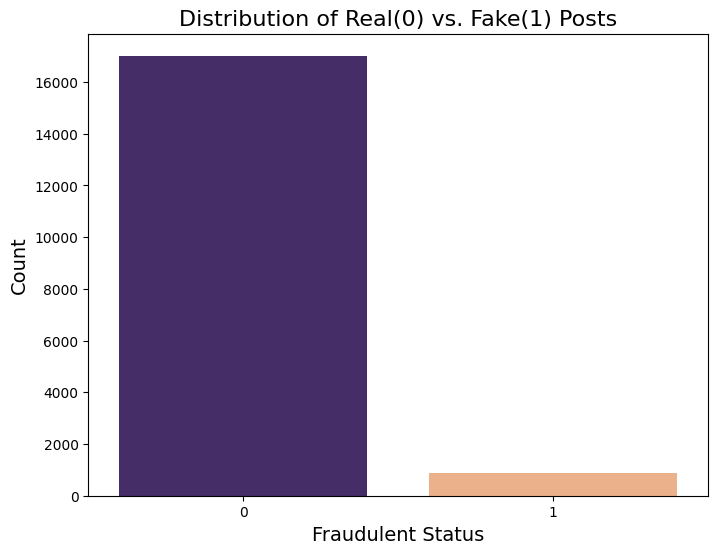

Target Distribution:
fraudulent
0    0.951566
1    0.048434
Name: proportion, dtype: float64

Analysis: The dataset is highly imbalanced, with fake posts being the minority class.


In [8]:
#@title 3. [EDA 보강] Target(fraudulent) 분포 확인 (영문 Plot)

if df is not None:
    plt.figure(figsize = (8, 6))
    sb.countplot(data=df, x='fraudulent', palette = ["#432371", "#FAAE7B"])
    plt.title("Distribution of Real(0) vs. Fake(1) Posts", fontsize = 16)
    plt.xlabel("Fraudulent Status", fontsize = 14)
    plt.ylabel("Count", fontsize = 14)
    plt.show()

    print(f"Target Distribution:\n{df.fraudulent.value_counts(normalize=True)}")
    print("\nAnalysis: The dataset is highly imbalanced, with fake posts being the minority class.")


In [11]:
#@title 4. 텍스트 데이터 결합 및 정제 (원본 로직 유지) 10분 소요

if df is not None:
    # 1. 원본의 결측치 처리 및 텍스트 컬럼 병합 로직
    df.fillna(" ", inplace = True)
    df['text'] = df['title'] + " " + df['department'] + \
                 " " + df['company_profile'] + " " + \
                 " " + df['description'] + " " + \
                 " " + df['requirements'] + " " + \
                 " " + df['benefits']

    # 2. 원본의 텍스트 정제 로직 (함수화하여 재사용)
    print("Cleaning and preprocessing text data... (This may take a few minutes)")

    def clean_and_lemmatize(text):
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.strip()
        text = nltk.word_tokenize(text)
        text = [word for word in text if not word in set(stopwords.words("english"))]
        lemma = nlp.WordNetLemmatizer()
        text = [lemma.lemmatize(word) for word in text]
        text = " ".join(text)
        text = text.replace('  ',' ')
        return text

    df['cleaned_text'] = df['text'].apply(clean_and_lemmatize)

    print("Text cleaning complete.")

Cleaning and preprocessing text data... (This may take a few minutes)
Text cleaning complete.


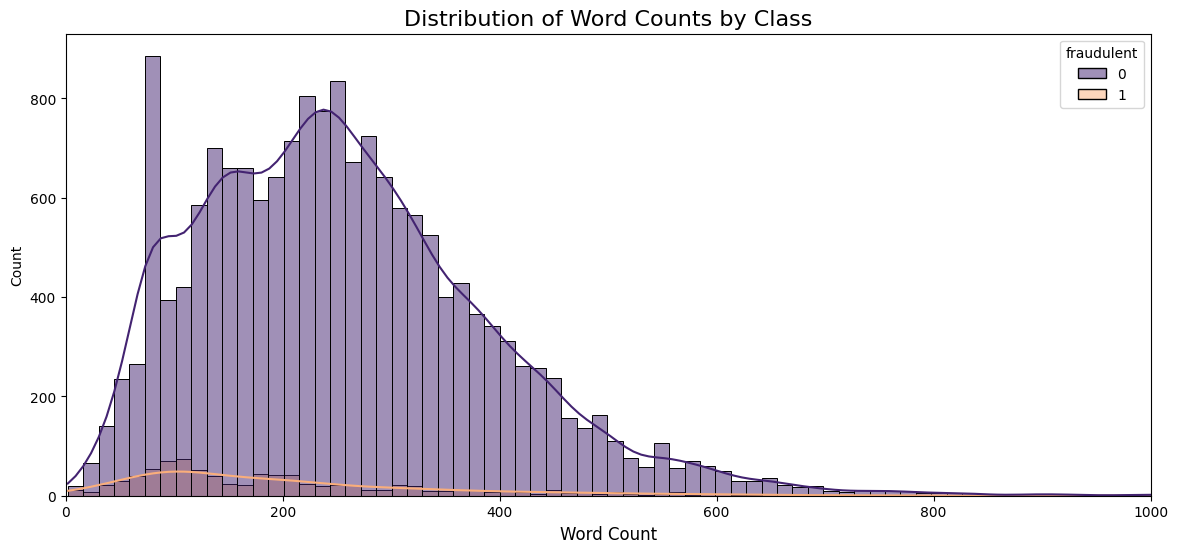

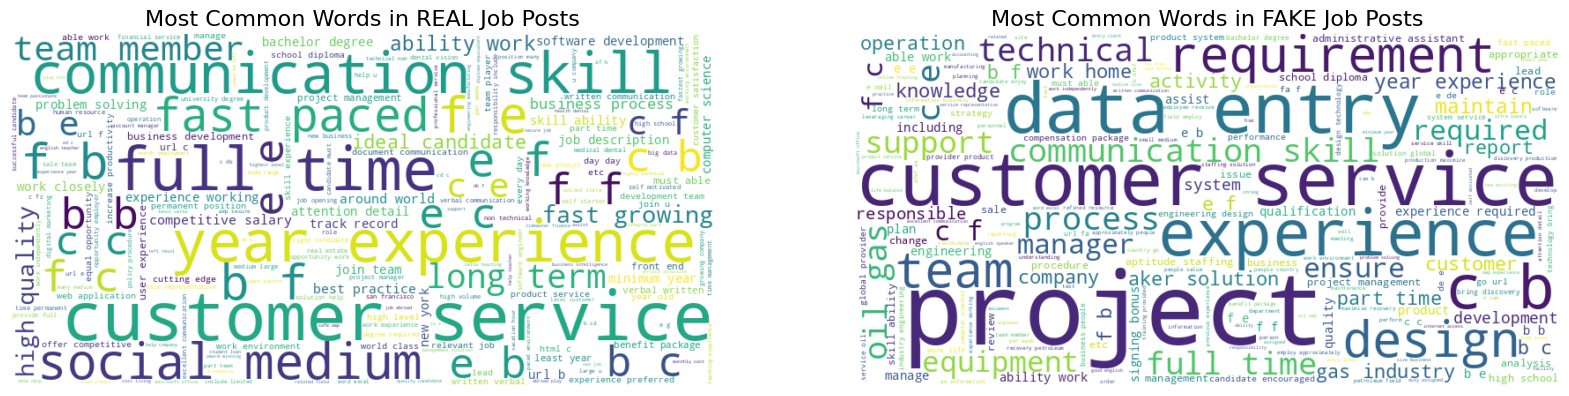

In [12]:
#@title 5. [EDA 보강] 텍스트 길이 및 주요 단어 분석 (영문 Plot)

if df is not None:
    df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))

    # 1. 텍스트 길이 분포
    plt.figure(figsize=(14, 6))
    sb.histplot(data=df, x='word_count', hue='fraudulent', bins=100, kde=True, palette=["#432371", "#FAAE7B"])
    plt.title('Distribution of Word Counts by Class', fontsize=16)
    plt.xlabel('Word Count', fontsize=12)
    plt.xlim(0, 1000) # (긴 꼬리 자르기)
    plt.show()

    # 2. 워드 클라우드
    real_jobs_text = " ".join(df[df.fraudulent == 0]['cleaned_text'])
    fake_jobs_text = " ".join(df[df.fraudulent == 1]['cleaned_text'])

    wc_real = WordCloud(width = 800, height = 400, background_color ='white').generate(real_jobs_text)
    wc_fake = WordCloud(width = 800, height = 400, background_color ='white').generate(fake_jobs_text)

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].imshow(wc_real, interpolation='bilinear')
    axes[0].set_title('Most Common Words in REAL Job Posts', fontsize=16)
    axes[0].axis("off")

    axes[1].imshow(wc_fake, interpolation='bilinear')
    axes[1].set_title('Most Common Words in FAKE Job Posts', fontsize=16)
    axes[1].axis("off")

    plt.show()

In [13]:
#@title 6. 텍스트 시퀀스 변환 (Tokenizer & Padding)

if df is not None:
    # 원본의 파라미터 유지
    max_features = 10000

    # 1. Tokenizer 생성 및 학습
    tokenizer = Tokenizer(num_words = max_features)
    tokenizer.fit_on_texts(df['cleaned_text'])

    # 2. 텍스트를 정수 시퀀스로 변환
    encoded_docs = tokenizer.texts_to_sequences(df['cleaned_text'])

    # 3. 패딩 (Padding)
    # EDA(Cell 5)에서 대부분의 텍스트 길이가 1000 미만이므로, maxlen을 적절히 설정
    sent_length = 500 # (원본은 전체 최대 길이를 사용했지만, 효율성을 위해 500으로 조정)
    embedded_docs = pad_sequences(encoded_docs, padding='pre', maxlen=sent_length)

    print(f"Padded sequences shape: {embedded_docs.shape}")

    # 4. X(Features) / y(Target) 분리
    X = np.array(embedded_docs)
    y = df.fraudulent.values

    # 5. Train / Test 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify=y)
else:
    print("Skipping sequence conversion as DataFrame is not loaded.")

Padded sequences shape: (17880, 500)


In [14]:
#@title 7. BiLSTM 모델 정의 및 컴파일

if 'X_train' in locals():
    # 원본의 BiLSTM 모델 구조
    embedding_vector_features = 40

    model = Sequential()
    model.add(Embedding(max_features, embedding_vector_features, input_length=sent_length))
    model.add(Bidirectional(LSTM(32))) # (유닛 수를 32로 조정)
    model.add(Dropout(0.5)) # (과적합 방지를 위한 Dropout 추가)
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print("BiLSTM Model built and compiled.")
    model.summary()
else:
    print("Skipping model creation as input data is not available.")

BiLSTM Model built and compiled.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
#@title 8. 모델 학습 (Callbacks 보강)
import os

if 'model' in locals():
    # [보강] 과적합 방지 및 최적 모델 저장을 위한 Callbacks
    model_path = os.path.join("/content/best_model", "best_bilstm_model.h5")

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    mc = ModelCheckpoint(model_path, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

    print("\nStarting model training...")
    history = model.fit(
        X_train,
        y_train,
        epochs=20, # (ES가 최적 Epochs를 찾도록 충분히 부여)
        batch_size=64,
        validation_data=(X_test, y_test),
        callbacks=[es, mc]
    )
    print("\nModel training finished.")

    # 최적 모델 로드
    best_model = load_model(model_path)
else:
    history = None
    best_model = None
    print("Skipping model training.")


Starting model training...
Epoch 1/20
223/224 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9296 - loss: 0.2632
Epoch 1: val_accuracy improved from -inf to 0.97176, saving model to /content/best_model/best_bilstm_model.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.9298 - loss: 0.2624 - val_accuracy: 0.9718 - val_loss: 0.0909
Epoch 2/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9758 - loss: 0.0789
Epoch 2: val_accuracy improved from 0.97176 to 0.97847, saving model to /content/best_model/best_bilstm_model.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.9758 - loss: 0.0789 - val_accuracy: 0.9785 - val_loss: 0.0761
Epoch 3/20
223/224 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9882 - loss: 0.0492
Epoch 3: val_accuracy improved from 0.97847 to 0.98043, saving model to /content/best_model/best_bilstm_model.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.9882 - loss: 0.0492 - val_accuracy: 0.9804 - val_loss: 0.0829
Epoch 4/20
223/224 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9922 - loss: 0.0323
Epoch 4: val_accuracy did not improve from 0.98043
224/224 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.9922 - loss: 0.0323 - val_accuracy: 0.9801 - val_loss: 0.0795
Epoch 5/20
223/224 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9945 - loss: 0.0235
Epoch 5: val_accuracy did not improve from 0.98043
224/224 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.9945 - loss: 0.0235 - val_accuracy: 0.9801 - val_loss: 0.0753
Epoch 6/20
223/224 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9979 - loss: 0.0132
Epoch 6: val_accuracy improved from 0.98043 to 0.98154, saving model to /content/best_model/best_bilstm_model.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9979 - loss: 0.0133 - val_accuracy: 0.9815 - val_loss: 0.0900
Epoch 7/20
223/224 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9981 - loss: 0.0104
Epoch 7: val_accuracy did not improve from 0.98154
224/224 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.9981 - loss: 0.0104 - val_accuracy: 0.9804 - val_loss: 0.0961
Epoch 8/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9991 - loss: 0.0066
Epoch 8: val_accuracy did not improve from 0.98154
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9991 - loss: 0.0066 - val_accuracy: 0.9796 - val_loss: 0.1211
Epoch 9/20
223/224 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9952 - loss: 0.0164
Epoch 9: val_accuracy did not improve from 0.98154
224/224 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.9952 - loss: 0.0163 - val_accuracy: 0.9779 - val_loss: 0.1114
Epoch 10/20
223/224 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9993 - loss: 0.0055
Epoch 10: val_accuracy 


Plotting training history...


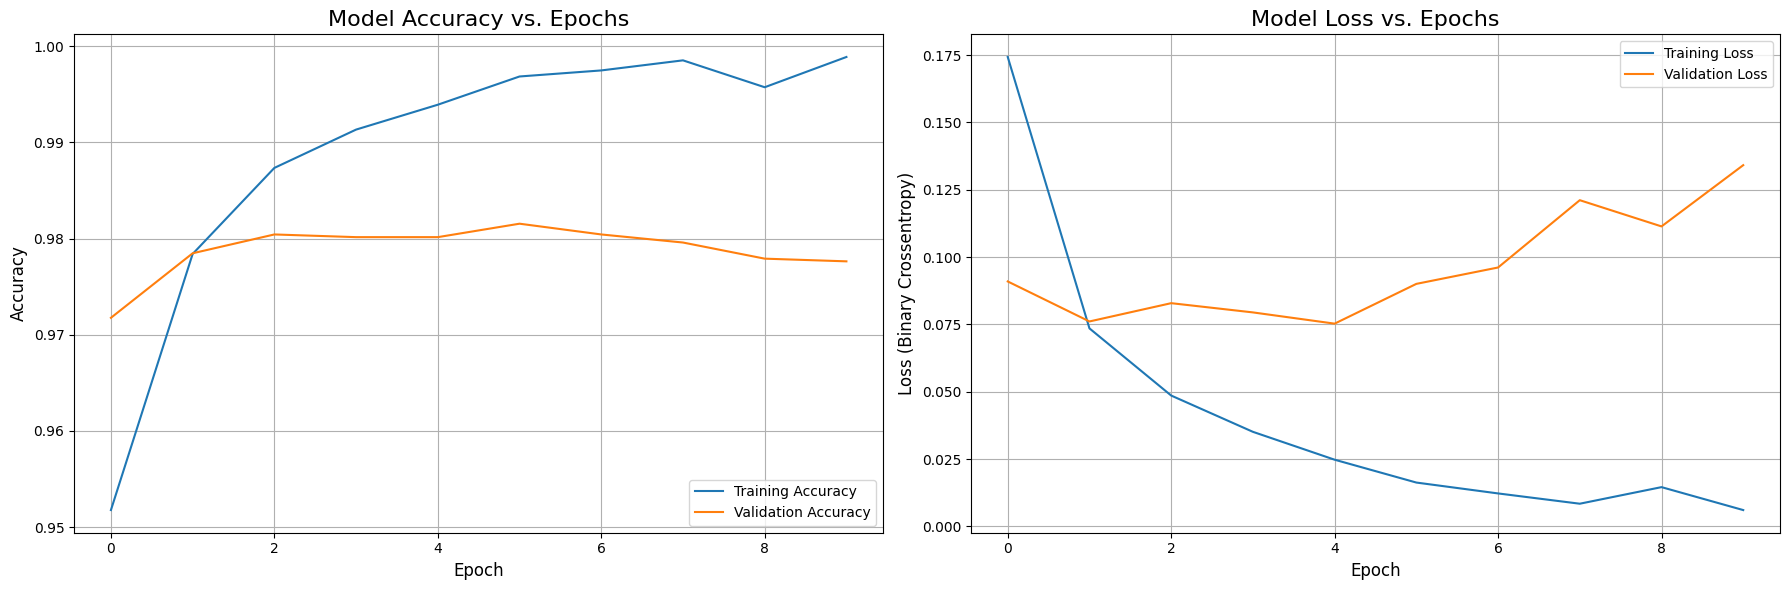

In [17]:
#@title 9. [결과 분석 보강] 학습 곡선 시각화 (Loss & Accuracy - 영문)

if history:
    print("\nPlotting training history...")
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

    # Accuracy Plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy vs. Epochs', fontsize=16)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(loc='lower right')
    ax1.grid(True)

    # Loss Plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss vs. Epochs', fontsize=16)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss (Binary Crossentropy)', fontsize=12)
    ax2.legend(loc='upper right')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


--- Final Model Evaluation on Test Set (Using Best Model) ---
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step

[Classification Report (English)]
              precision    recall  f1-score   support

    Real (0)       0.98      1.00      0.99      3403
    Fake (1)       0.93      0.66      0.78       173

    accuracy                           0.98      3576
   macro avg       0.96      0.83      0.88      3576
weighted avg       0.98      0.98      0.98      3576


Plotting Confusion Matrix...


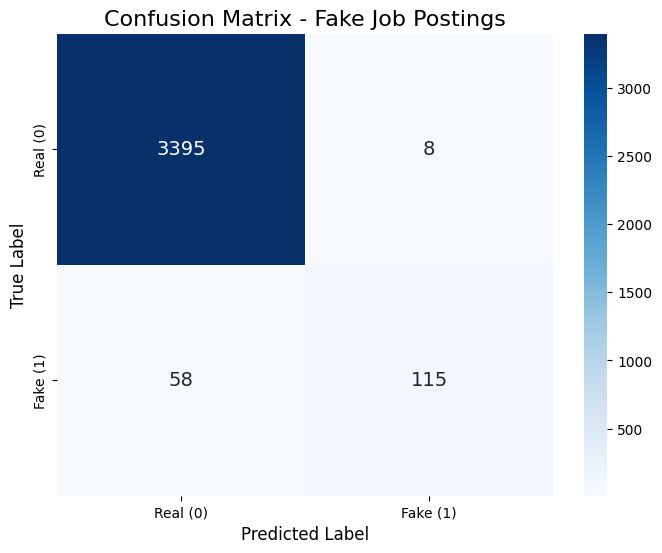

In [18]:
#@title 10. [결과 분석] 최종 평가 (리포트 및 혼동 행렬 - 원본 기반 + 개선)

if best_model:
    print("\n--- Final Model Evaluation on Test Set (Using Best Model) ---")

    # 1. 예측 수행
    y_pred_probs = best_model.predict(X_test)
    y_pred_class = (y_pred_probs > 0.5).astype("int32")

    # 2. 분류 리포트 (원본 로직)
    print("\n[Classification Report (English)]")
    print(classification_report(y_test, y_pred_class, target_names=['Real (0)', 'Fake (1)']))

    # 3. [개선] 혼동 행렬 시각화
    print("\nPlotting Confusion Matrix...")
    cm = confusion_matrix(y_test, y_pred_class)

    plt.figure(figsize=(8, 6))
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Real (0)', 'Fake (1)'],
               yticklabels=['Real (0)', 'Fake (1)'],
               annot_kws={"size": 14})
    plt.title('Confusion Matrix - Fake Job Postings', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()